# Design Patterns

Here are a number of common patterns that you often come across in parallel programming, both in models and data analysis

## Halos

It's common to break up a large dataset horizontally into a grid, with each part of the grid running on a different processor, especially in models.

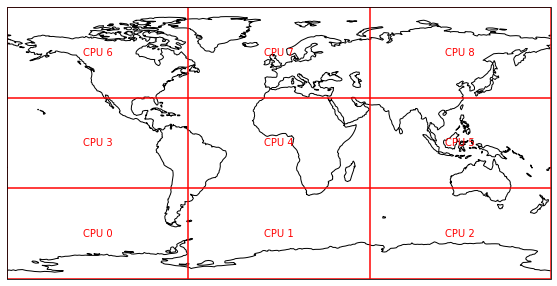

In [31]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy

plt.figure(figsize=(10,5))

def cpu_decompose():

    lats = numpy.linspace(-90,90,num=4)
    lons = numpy.linspace(-180,180,num=4)

    ax = plt.axes(projection=ccrs.PlateCarree())

    for lat in lats:
        plt.plot([-180,180],[lat,lat], color='r')

    for lon in lons:
        plt.plot([lon,lon],[-90,90], color='r')



    ax.coastlines();
    
    return ax, lats, lons
    
ax, lats, lons = cpu_decompose()

n = 0
for lat in lats[:-1] + numpy.diff(lats)/2:
    for lon in lons[:-1] + numpy.diff(lons)/2:
        plt.text(lon, lat, f"CPU {n}", ha='center', va='center', color='r')
        n+=1

Each processor works on its own domain of the full grid, and since the vast majority of calculations done in a model are fairly local (the main exception is radiation) the individual processors don't need to interact much. Where they do need to interact is at the edges of the domains, since to calcuate gradients and the like at the edges you need to know the field values on both sides of the boundary.

This is normally accomplished by the actual grid held on each processor being a bit larger than the domain it works on, generally by a few grid points in each direction. This 'halo' around the domain gets read from neighbouring processors, e.g. with MPI messages. In a model the calculations are organised so that halo exchanges happen as few times as possible, since communication is generally relatively slow so should be avoided when possible.

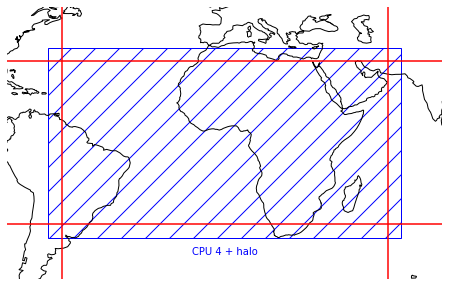

In [54]:
from matplotlib.patches import Rectangle

plt.figure(figsize=(10,5))
ax, lats, lons = cpu_decompose()

ax.set_xlim(lons[1] - 20, lons[2] + 20)
ax.set_ylim(lats[1] - 20, lats[2] + 20)

ax.fill([lons[1] - 5, lons[2] + 5, lons[2] + 5, lons[1] - 5], [lats[1]-5, lats[1]-5, lats[2]+5,lats[2]+5], hatch='/', fill=None, color='b')
plt.text(lons[1] + (lons[2] - lons[1])/2, lats[1] - 10, f"CPU 4 + halo", ha='center', va='center', color='b')

plt.box()

### Fortran

In fortran you can set up array indices so that the data within the domain is indexed normally from 1 to N, but if you read beyond the domain then the data comes from the halo. Here when `i=1`, `a(i-1,j)` gets read from the halo data. 

```fortran
integer, parameter :: nx = 20
integer, parameter :: ny = 10
integer, parameter :: halo = 2

real :: a(-halo + 1:nx + halo, -halo + 1:ny + halo)
real :: b(-halo + 1:nx + halo, -halo + 1:ny + halo)

integer :: i, j

do j=1,ny
    do i=1,nx
        b(i, j) = a(i - 1, j)/2 + a(i, j) + a(i + 1, j)/2
```

The current process only ever writes to its own domain, never to the halo apart from the updates from the other processors.

### Python

When working with Dask arrays, the `map_overlap` routine can set up halos for you. https://docs.dask.org/en/latest/array-overlap.html